<a href="https://colab.research.google.com/github/seemab21/Thesis_Transformer_model/blob/main/EL(HES%2BHER)Transformer_Model_Activity_Recognition_PD_K_fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup & Dependencies**

In [1]:
import os
import math
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW

from imblearn.over_sampling import RandomOverSampler

from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR

import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


# **Config**

In [2]:
root_dir = '/content/drive/MyDrive/IMU/Annotated_Data'
groups = ['PD','EL']
frame_size = 100
feature_cols = [
    'left acceleration X[g]',
    'left acceleration Y[g]',
    'left acceleration Z[g]',
    'left angular X[dps]',
    'left angular Y[dps]',
    'left angular Z[dps]',
]
label_map = {'HES': 0, 'HER': 1, 'TOF': 2, 'FOF': 3}

# **Warmup Scheduler Function**

In [3]:
def get_linear_warmup_scheduler(optimizer, warmup_steps):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        return 1.0
    return LambdaLR(optimizer, lr_lambda)


# **Data Loading & Frame Building**

In [4]:
# Function to process a single file
def process_file(filepath, group=None):
    data = pd.read_excel(filepath)
    data = data.dropna(subset=feature_cols + ['Event- Label level 2- Left Foot'])
    data['label'] = data['Event- Label level 2- Left Foot'].map(label_map)
    data = data.dropna(subset=['label'])
    data['label'] = data['label'].astype(int)

    frames = []
    labels = []
    for i in range(0, len(data) - frame_size + 1, frame_size):
        segment = data.iloc[i:i + frame_size]
        label = np.bincount(segment['label']).argmax()

        # Filter EL group to only keep HES and HER frames
        if group == 'EL' and label not in [0, 1]:
            continue

        frame = segment[feature_cols].values.flatten()
        frames.append(frame)
        labels.append(label)

    return frames, labels



# Function to load data from multiple groups and preprocess it
def load_all_group_data(root_dir, groups):
    all_frames = []
    all_labels = []
    skipped_files_count = 0
    a_frame = {i: [] for i in range(frame_size * len(feature_cols))}  # For flattened frames
    a_frame['label'] = []  # For labels

    for group in groups:
        group_path = os.path.join(root_dir, group)

        for file_name in os.listdir(group_path):
            if file_name.endswith('.xlsx'):
                filepath = os.path.join(group_path, file_name)

                try:
                    # Pass group info to process_file to filter EL frames
                    frames, labels = process_file(filepath, group=group)

                    all_frames.extend(frames)
                    all_labels.extend(labels)

                    for frame, label in zip(frames, labels):
                        for i, val in enumerate(frame):
                            a_frame[i].append(val)
                        a_frame['label'].append(label)

                except KeyError as e:
                    print(f"File skipped due to missing columns: {filepath}")
                    print(f"Missing columns error: {e}")
                    skipped_files_count += 1
                    continue

    all_frames = np.array(all_frames)
    all_labels = np.array(all_labels, dtype=int)

    print(f"Total files skipped due to missing columns: {skipped_files_count}")

    # Print label counts
    unique, counts = np.unique(all_labels, return_counts=True)
    print("Labels distribution after loading:")
    for u, c in zip(unique, counts):
        print(f"Label {u} ({list(label_map.keys())[u]}): {c}")

    # Plot label distribution
    import matplotlib.pyplot as plt
    labels_names = [list(label_map.keys())[u] for u in unique]
    plt.figure(figsize=(8,5))
    plt.bar(labels_names, counts, color='skyblue')
    plt.title("Label Counts After Loading Data")
    plt.xlabel("Class")
    plt.ylabel("Number of Frames")
    plt.show()

    # Convert to DataFrame for any downstream use
    df = pd.DataFrame(a_frame)

    return all_frames, all_labels


# Function to compute class weights for imbalanced datasets
# def compute_class_weights(labels):
#    label_counts = np.bincount(labels)
#    total = len(labels)

#    # Class weight formula to handle class imbalance
#   weights = [total / (2 * c) if c > 0 else 0 for c in label_counts]

#    return torch.tensor(weights, dtype=torch.float32)

def compute_class_weights(labels, num_classes):
    classes = np.arange(num_classes)
    w = compute_class_weight(class_weight='balanced',
                             classes=classes,
                             y=labels)
    return torch.tensor(w, dtype=torch.float32)

# **Dataset & DataLoader**

In [5]:
class IMUDataset(Dataset):
    def __init__(self, x, y):
        self.X = torch.tensor(x, dtype=torch.float32).reshape(-1, 100, 6)
        self.Y = torch.tensor(y, dtype=torch.long).squeeze()

    def __len__(self):
      return len(self.Y)
    def __getitem__(self, idx):
      return self.X[idx], self.Y[idx]


# **Transformer Model**

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.3, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, drop_prob=0.3):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model, ffn_hidden)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        # Multi-head self-attention with residual and norm
        _x = x
        x = self.attn(x)
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        # Feed-forward network with residual and norm
        _x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + _x)

        return x


class Encoder(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, n_layers, drop_prob=0.3):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_head, ffn_hidden, drop_prob=drop_prob)
            for _ in range(n_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x



In [7]:
class ClassificationHead(nn.Module):
    def __init__(self, d_model, seq_len, n_classes=4, drop_prob=0.3):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.seq = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * seq_len, 512),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),      # Added dropout
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),      # Added dropout
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),      # Added dropout
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.norm(x)
        x = self.seq(x)
        return x


In [8]:
class TransformerModel(nn.Module):
    def __init__(self, d_model=128, n_head=4, n_layers=4, seq_len=100, hidden=128, num_classes=4, drop_prob=0.3):
        super().__init__()

        # Input projection layer
        self.input_proj = nn.Linear(6, d_model)

        # Positional encoding layer
        self.pos_enc = PositionalEncoding(d_model)

        # Encoder: Adding dropout to each EncoderLayer
        self.encoder = nn.Sequential(*[
            EncoderLayer(d_model, n_head, hidden, drop_prob) for _ in range(n_layers)
        ])

        self.classifier = ClassificationHead(
            d_model=d_model, seq_len=seq_len, n_classes=num_classes
        )

    def forward(self, x):
        # Project input to d_model
        x = self.input_proj(x)

        # Apply positional encoding
        x = self.pos_enc(x)

        # Pass through the encoder layers
        x = self.encoder(x)

        # Pass through the classifier
        return self.classifier(x)


class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):
        # Compute scaled dot-product attention
        d_k = q.size(-1)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
        attn = self.softmax(scores)

        return torch.matmul(attn, v), attn



class LayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))

        self.eps = 1e-6


    def forward(self, x):
        # Normalize across the last dimension
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim, drop_prob=0.3):
        super().__init__()

        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.Linear(hidden_dim, d_model)
        )

    def forward(self, x):
        return self.ffn(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()

        self.n_head = n_head
        self.attn = ScaleDotProductAttention()

        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.shape

        qkv = self.qkv_proj(x).reshape(B, T, self.n_head, -1).permute(2, 0, 1, 3)
        q, k, v = torch.chunk(qkv, 3, dim=-1)

        out, _ = self.attn(q, k, v)
        out = out.permute(1, 2, 0, 3).reshape(B, T, C)

        return self.out_proj(out)

# **Training & Evaluation**

In [20]:
##### FOCAL LOSS

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # Tensor of class weights or None
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)  # pt = predicted probability of true class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [21]:
def calc_loss(outputs, targets, class_weights, metrics):
    focal_loss_fn = FocalLoss(alpha=class_weights.to(device), gamma=1.5)
    ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))

    focal_loss = focal_loss_fn(outputs, targets)
    ce_loss = ce_loss_fn(outputs, targets)

    loss = 0.7 * focal_loss + 0.3 * ce_loss  # Adjust weights as needed

    metrics['loss'].append(loss.item())
    _, preds = torch.max(outputs, 1)
    metrics['correct'] += (preds == targets).sum().item()
    metrics['total'] += targets.size(0)

    return loss


In [9]:
def calc_loss(outputs, targets, class_weights, metrics):
    loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
    loss = loss_fn(outputs, targets)

    metrics['loss'].append(loss.item())
    _, preds = torch.max(outputs, 1)
    metrics['correct'] += (preds == targets).sum().item()
    metrics['total'] += targets.size(0)

    return loss

def train_model(model, dataloaders, optimizer, weights, epochs, patience, scheduler=None, scheduler_step_per_batch=False):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train': [], 'val': []}
    epochs_no_improve = 0
    stop_training = False

    # Initialize the learning rate scheduler
    # scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            metrics = {'loss': [], 'correct': 0, 'total': 0}

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    out = model(inputs)
                    loss = calc_loss(out, labels, weights, metrics)
                    if phase == 'train':
                      loss.backward();
                      optimizer.step()
                      if scheduler and scheduler_step_per_batch:
                          scheduler.step()

            epoch_loss = np.mean(metrics['loss'])
            epoch_acc = 100 * metrics['correct'] / metrics['total']
            history[phase].append((epoch_loss, epoch_acc))

            # Save model if it improves on validation loss
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    print(" Best model updated!")
                else:
                    epochs_no_improve += 1

                # Step the scheduler with the validation loss after each epoch
                # if scheduler:
                #    scheduler.step(epoch_loss)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs!")
                stop_training = True
                break

        if stop_training:
            break


    model.load_state_dict(best_model_wts)
    return model, history

def plot_metrics(history):
    epochs = range(1, len(history['train']) + 1)
    train_loss, train_acc = zip(*history['train'])
    val_loss, val_acc = zip(*history['val'])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, val_loss, label='Val')
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train')
    plt.plot(epochs, val_acc, label='Val')
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.show()

def evaluate_model(model, dataloader, save_path=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute performance metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("\nFinal Validation Metrics:")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall   : {rec * 100:.2f}%")
    print(f"F1 Score : {f1 * 100:.2f}%")


    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to: {save_path}")
    plt.show()

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

In [10]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

def cross_validate_model(frames, labels, num_classes, batch_size, epochs, patience, learning_rate, root_dir, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(frames, labels), 1):
        print(f"\n--- Fold {fold} / {k} ---")

        x_train, y_train = frames[train_idx], labels[train_idx]
        x_val, y_val = frames[val_idx], labels[val_idx]

        # --- Step 1: Oversample label 1 (HER) to 400 samples ---
        ros = RandomOverSampler(sampling_strategy={1: 400}, random_state=42)
        x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)

        # Print label counts after oversampling
        label_counts = Counter(y_train_resampled)
        print(f"Label counts after oversampling in fold {fold}: {dict(label_counts)}")

        # Create dataloaders with oversampled training data
        dataloaders = {
            'train': DataLoader(IMUDataset(x_train_resampled, y_train_resampled), batch_size=batch_size, shuffle=True),
            'val': DataLoader(IMUDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
        }

        model = TransformerModel().to(device)
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

        warmup_steps = 200
        scheduler = get_linear_warmup_scheduler(optimizer, warmup_steps=warmup_steps)

        # Compute class weights on resampled data and normalize
        class_weights = compute_class_weights(y_train_resampled, num_classes)
        class_weights = class_weights / class_weights.max()
        print(f"Class weights after oversampling in fold {fold}: {class_weights}")

        trained_model, history = train_model(
            model, dataloaders, optimizer, class_weights, epochs, patience,
            scheduler=scheduler, scheduler_step_per_batch=True
        )
        plot_metrics(history)

        metrics = evaluate_model(
            trained_model, dataloaders['val'],
            save_path=f"{root_dir}/confusion_matrix_fold{fold}.png"
        )
        metrics['fold'] = fold  # Add fold number to metrics dict
        fold_metrics.append(metrics)

        torch.save(trained_model.state_dict(), f"{root_dir}/transformer_fold{fold}.pth")

    # Save all fold metrics to CSV
    df_metrics = pd.DataFrame(fold_metrics)
    csv_path = f"{root_dir}/cross_validation_metrics.csv"
    df_metrics.to_csv(csv_path, index=False)
    print(f"\nSaved cross-validation metrics to {csv_path}")

    # Print average metrics
    avg_acc = df_metrics['accuracy'].mean()
    avg_prec = df_metrics['precision'].mean()
    avg_rec = df_metrics['recall'].mean()
    avg_f1 = df_metrics['f1'].mean()

    print(f"\nAverage metrics over {k} folds:")
    print(f"Accuracy : {avg_acc:.4f}")
    print(f"Precision: {avg_prec:.4f}")
    print(f"Recall   : {avg_rec:.4f}")
    print(f"F1 Score : {avg_f1:.4f}")

    return fold_metrics


**Warmup_steps Calculation**

1285 samples total

batch size is 16

**batches per epoch: 81**

For 2 epochs warmup: warmup_steps = 81 × 2 = **162**

For 3 epochs warmup: warmup_steps = 81×3 = **243**

Set warmup_steps somewhere between **150** to **250**

**Warmup_steps = 200**

In [11]:
# Hyperparameters
num_classes = 4
learning_rate = 5e-5
batch_size = 16
epochs = 100
patience = 15

# **Run Everything**

File skipped due to missing columns: /content/drive/MyDrive/IMU/Annotated_Data/PD/pd004_1norm2.xlsx
Missing columns error: ['left acceleration X[g]', 'left acceleration Y[g]', 'left acceleration Z[g]', 'left angular X[dps]', 'left angular Y[dps]', 'left angular Z[dps]']


/tmp/ipython-input-4-2584014699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['Event- Label level 2- Left Foot'].map(label_map)
/tmp/ipython-input-4-2584014699.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].astype(int)


Total files skipped due to missing columns: 1
Labels distribution after loading:
Label 0 (HES): 568
Label 1 (HER): 155
Label 2 (TOF): 451
Label 3 (FOF): 500


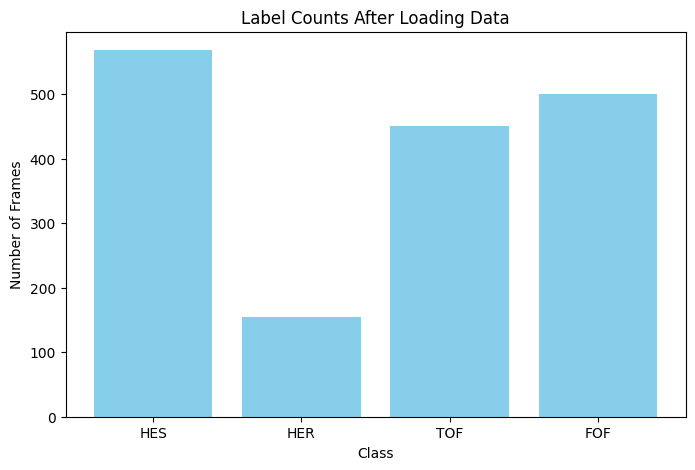

In [12]:
frames, labels = load_all_group_data(root_dir, groups)

Unique labels in dataset: [0 1 2 3]
Counts per label: [568 155 451 500]


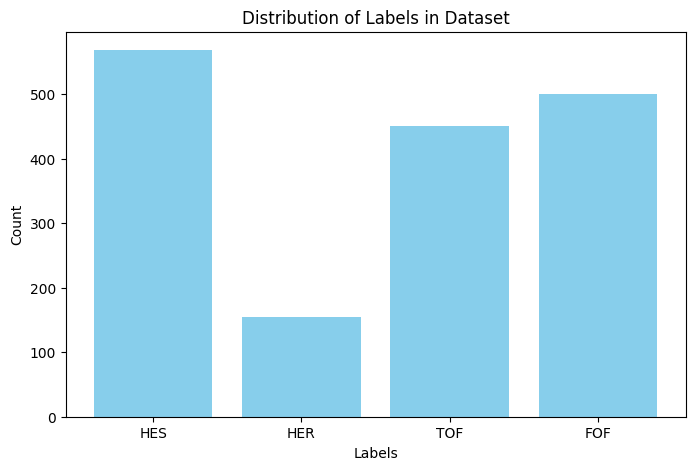

In [13]:
#### DEBUG ####
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Unique labels in dataset: {unique_labels}")
print(f"Counts per label: {counts}")

assert np.all((labels >= 0) & (labels < len(label_map))), "Some labels are out of expected range!"

# Map numeric labels back to their string names for plotting
label_names = list(label_map.keys())

plt.figure(figsize=(8,5))
plt.bar(label_names, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in Dataset')
plt.show()

In [14]:
# Apply global normalization across all frames
scaler = StandardScaler()
frames = scaler.fit_transform(frames)

In [15]:
print(f"Data shape (frames): {frames.shape}")  # e.g., (num_samples, frame_size*features)
print(f"Labels distribution: {np.bincount(labels)}")
print(f"Unique labels: {np.unique(labels)}")
print(f"Unique labels and counts: {np.unique(labels, return_counts=True)}")

print(f"Sample features (first frame, first 10 values): {frames[0][:10]}")

#print(f"Class weights: {class_weights.numpy()}")

Data shape (frames): (1674, 600)
Labels distribution: [568 155 451 500]
Unique labels: [0 1 2 3]
Unique labels and counts: (array([0, 1, 2, 3]), array([568, 155, 451, 500]))
Sample features (first frame, first 10 values): [ 0.20977889 -0.16970425 -0.22708322 -0.02963546  0.04257164  0.07577231
  0.20750187 -0.20505847 -0.20613849 -0.02831313]


**label mapping** {'HES': 0, 'HER': 1, 'TOF': 2, 'FOF': 3}


--- Fold 1 / 5 ---
Label counts after oversampling in fold 1: {np.int64(3): 400, np.int64(2): 360, np.int64(1): 400, np.int64(0): 455}
Class weights after oversampling in fold 1: tensor([0.7912, 0.9000, 1.0000, 0.9000])

Epoch 1/100
------------------------------
Train Loss: 1.3848 | Accuracy: 28.79%
 Best model updated!
Val Loss: 1.3476 | Accuracy: 31.04%

Epoch 2/100
------------------------------
Train Loss: 1.3310 | Accuracy: 36.28%
 Best model updated!
Val Loss: 1.1473 | Accuracy: 52.24%

Epoch 3/100
------------------------------
Train Loss: 1.1656 | Accuracy: 47.74%
Val Loss: 1.1868 | Accuracy: 49.25%

Epoch 4/100
------------------------------
Train Loss: 1.1080 | Accuracy: 49.97%
 Best model updated!
Val Loss: 1.1114 | Accuracy: 50.15%

Epoch 5/100
------------------------------
Train Loss: 1.0576 | Accuracy: 50.90%
Val Loss: 1.1267 | Accuracy: 50.15%

Epoch 6/100
------------------------------
Train Loss: 1.0138 | Accuracy: 54.12%
 Best model updated!
Val Loss: 1.0649 | Accu

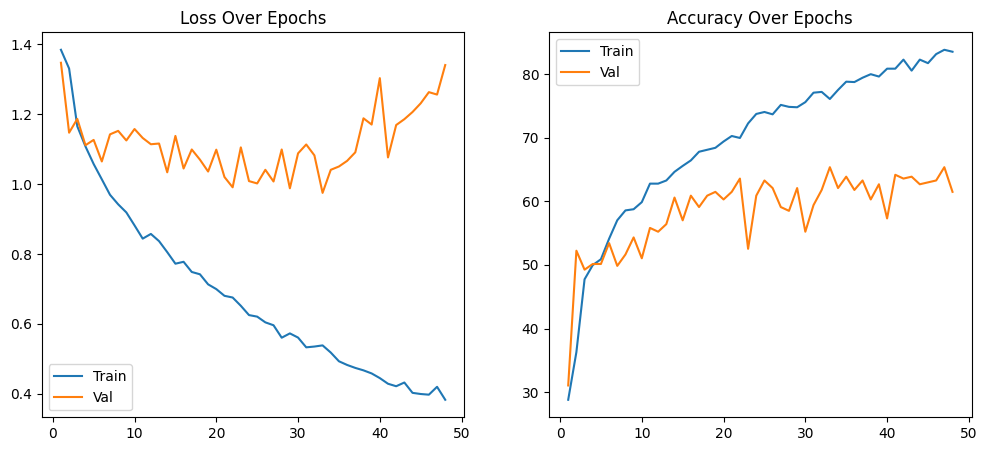


Final Validation Metrics:
Accuracy : 65.37%
Precision: 71.16%
Recall   : 65.37%
F1 Score : 64.45%
Confusion matrix saved to: /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/confusion_matrix_fold1.png


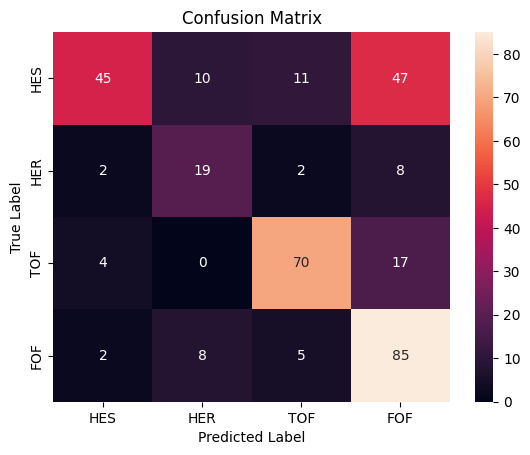


--- Fold 2 / 5 ---
Label counts after oversampling in fold 2: {np.int64(3): 400, np.int64(2): 361, np.int64(1): 400, np.int64(0): 454}
Class weights after oversampling in fold 2: tensor([0.7952, 0.9025, 1.0000, 0.9025])

Epoch 1/100
------------------------------
Train Loss: 1.3833 | Accuracy: 28.61%
 Best model updated!
Val Loss: 1.3431 | Accuracy: 38.51%

Epoch 2/100
------------------------------
Train Loss: 1.3136 | Accuracy: 38.64%
 Best model updated!
Val Loss: 1.1562 | Accuracy: 46.57%

Epoch 3/100
------------------------------
Train Loss: 1.1376 | Accuracy: 49.10%
Val Loss: 1.1701 | Accuracy: 48.06%

Epoch 4/100
------------------------------
Train Loss: 1.0828 | Accuracy: 50.28%
Val Loss: 1.2181 | Accuracy: 47.16%

Epoch 5/100
------------------------------
Train Loss: 1.0224 | Accuracy: 54.55%
Val Loss: 1.2275 | Accuracy: 49.25%

Epoch 6/100
------------------------------
Train Loss: 1.0018 | Accuracy: 56.28%
Val Loss: 1.1800 | Accuracy: 52.24%

Epoch 7/100
----------------

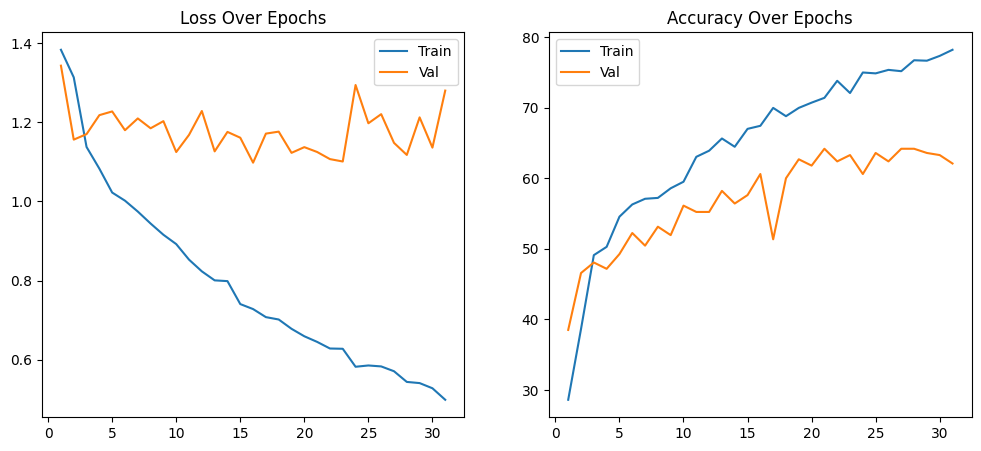


Final Validation Metrics:
Accuracy : 60.60%
Precision: 64.22%
Recall   : 60.60%
F1 Score : 58.68%
Confusion matrix saved to: /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/confusion_matrix_fold2.png


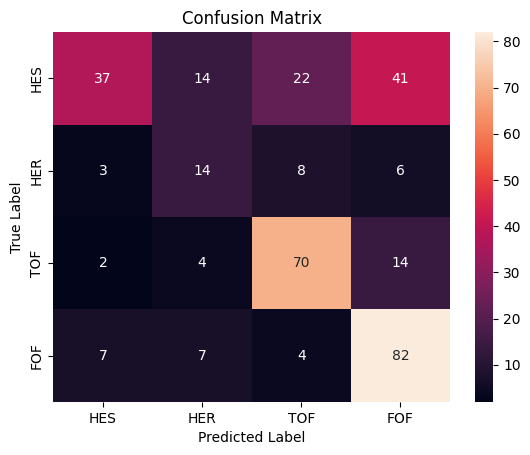


--- Fold 3 / 5 ---
Label counts after oversampling in fold 3: {np.int64(3): 400, np.int64(2): 361, np.int64(1): 400, np.int64(0): 454}
Class weights after oversampling in fold 3: tensor([0.7952, 0.9025, 1.0000, 0.9025])

Epoch 1/100
------------------------------
Train Loss: 1.3847 | Accuracy: 27.80%
 Best model updated!
Val Loss: 1.3666 | Accuracy: 39.40%

Epoch 2/100
------------------------------
Train Loss: 1.3353 | Accuracy: 35.60%
 Best model updated!
Val Loss: 1.2488 | Accuracy: 40.90%

Epoch 3/100
------------------------------
Train Loss: 1.1803 | Accuracy: 45.70%
 Best model updated!
Val Loss: 1.1313 | Accuracy: 48.66%

Epoch 4/100
------------------------------
Train Loss: 1.1173 | Accuracy: 48.61%
 Best model updated!
Val Loss: 1.0931 | Accuracy: 49.55%

Epoch 5/100
------------------------------
Train Loss: 1.0683 | Accuracy: 51.70%
Val Loss: 1.0961 | Accuracy: 53.13%

Epoch 6/100
------------------------------
Train Loss: 1.0516 | Accuracy: 52.94%
 Best model updated!
Va

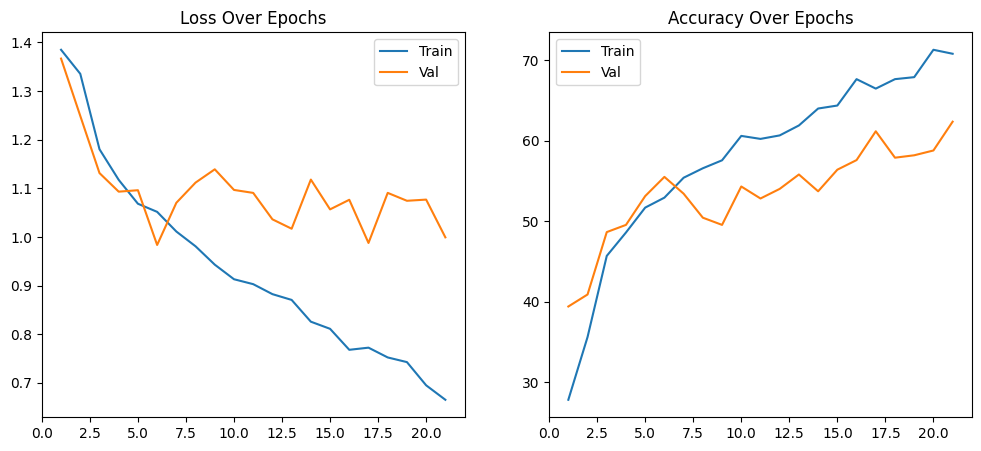


Final Validation Metrics:
Accuracy : 55.52%
Precision: 58.06%
Recall   : 55.52%
F1 Score : 49.21%
Confusion matrix saved to: /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/confusion_matrix_fold3.png


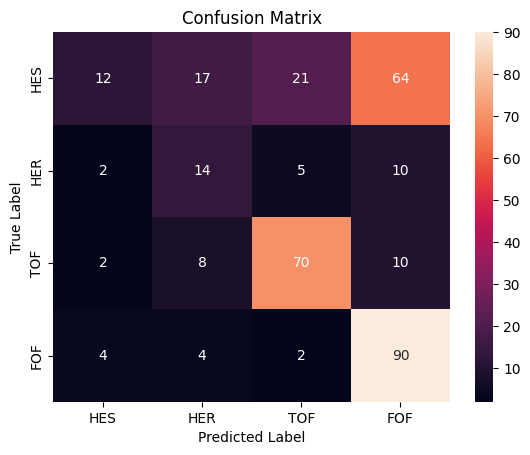


--- Fold 4 / 5 ---
Label counts after oversampling in fold 4: {np.int64(3): 400, np.int64(2): 361, np.int64(1): 400, np.int64(0): 454}
Class weights after oversampling in fold 4: tensor([0.7952, 0.9025, 1.0000, 0.9025])

Epoch 1/100
------------------------------
Train Loss: 1.3826 | Accuracy: 26.81%
 Best model updated!
Val Loss: 1.3293 | Accuracy: 40.00%

Epoch 2/100
------------------------------
Train Loss: 1.3091 | Accuracy: 37.59%
 Best model updated!
Val Loss: 1.1743 | Accuracy: 47.76%

Epoch 3/100
------------------------------
Train Loss: 1.1626 | Accuracy: 48.42%
 Best model updated!
Val Loss: 1.1334 | Accuracy: 48.66%

Epoch 4/100
------------------------------
Train Loss: 1.0992 | Accuracy: 50.34%
Val Loss: 1.1534 | Accuracy: 49.25%

Epoch 5/100
------------------------------
Train Loss: 1.0525 | Accuracy: 52.76%
Val Loss: 1.2718 | Accuracy: 47.46%

Epoch 6/100
------------------------------
Train Loss: 1.0200 | Accuracy: 55.05%
Val Loss: 1.1633 | Accuracy: 51.64%

Epoch 7

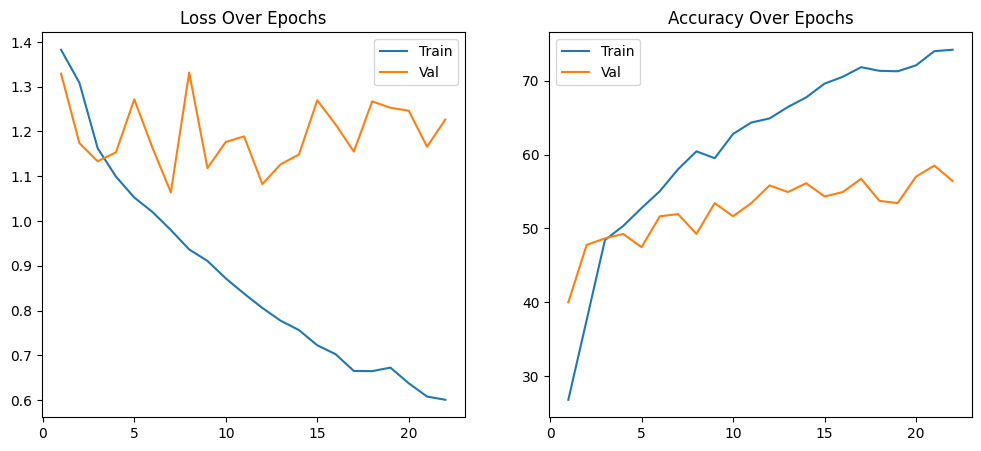


Final Validation Metrics:
Accuracy : 51.94%
Precision: 50.81%
Recall   : 51.94%
F1 Score : 47.25%
Confusion matrix saved to: /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/confusion_matrix_fold4.png


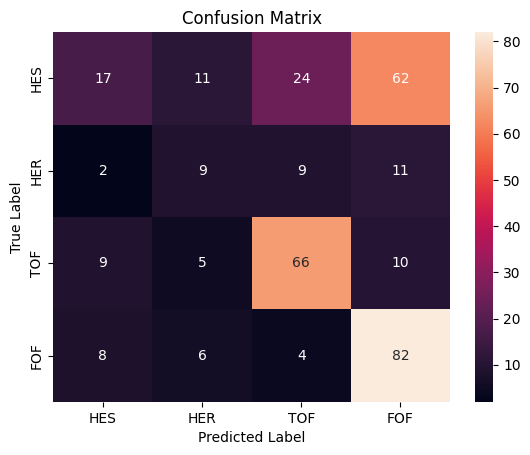


--- Fold 5 / 5 ---
Label counts after oversampling in fold 5: {np.int64(3): 400, np.int64(2): 361, np.int64(1): 400, np.int64(0): 455}
Class weights after oversampling in fold 5: tensor([0.7934, 0.9025, 1.0000, 0.9025])

Epoch 1/100
------------------------------
Train Loss: 1.3823 | Accuracy: 28.28%
 Best model updated!
Val Loss: 1.3544 | Accuracy: 38.62%

Epoch 2/100
------------------------------
Train Loss: 1.3115 | Accuracy: 36.32%
 Best model updated!
Val Loss: 1.1153 | Accuracy: 52.10%

Epoch 3/100
------------------------------
Train Loss: 1.1620 | Accuracy: 46.91%
 Best model updated!
Val Loss: 1.0689 | Accuracy: 51.50%

Epoch 4/100
------------------------------
Train Loss: 1.1243 | Accuracy: 49.20%
Val Loss: 1.0933 | Accuracy: 53.59%

Epoch 5/100
------------------------------
Train Loss: 1.0823 | Accuracy: 50.62%
Val Loss: 1.1038 | Accuracy: 51.80%

Epoch 6/100
------------------------------
Train Loss: 1.0514 | Accuracy: 53.22%
Val Loss: 1.0997 | Accuracy: 53.29%

Epoch 7

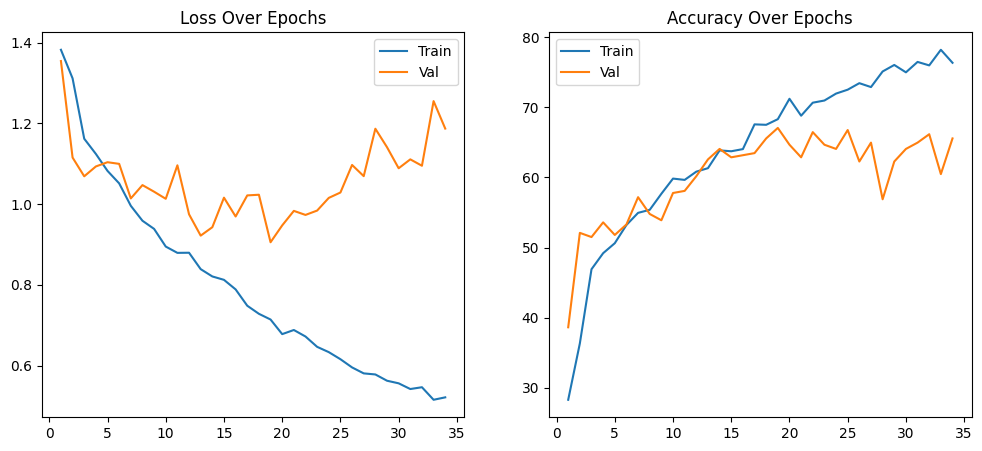


Final Validation Metrics:
Accuracy : 67.07%
Precision: 69.16%
Recall   : 67.07%
F1 Score : 65.87%
Confusion matrix saved to: /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/confusion_matrix_fold5.png


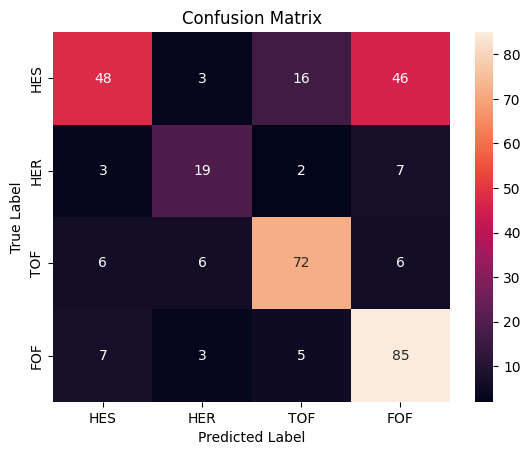


Saved cross-validation metrics to /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/cross_validation_metrics.csv

Average metrics over 5 folds:
Accuracy : 0.6010
Precision: 0.6268
Recall   : 0.6010
F1 Score : 0.5709


In [16]:
save_dir = '/content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD'

fold_metrics = cross_validate_model(
    frames=frames,
    labels=labels,
    num_classes=num_classes,
    batch_size=batch_size,
    epochs=epochs,
    patience=patience,
    learning_rate=learning_rate,
    root_dir=save_dir,
    k=5
)